# Testing on (E)MNIST with batch shrinking

In [1]:
from LSH_reduction import *
from resnet18_model_wbs import *
import math
import time
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch
from random import choices
import copy
import os
import subprocess
from torchvision import transforms
import torch.nn as nn
import csv
import copy

cos_sim = lambda a,b: np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b))

In [3]:
def accuracy(rp, p, shrinkage = 'LSH'):
    global trainset
    global testset
    global net
    t0 = time.time()
    
    learning_rate = 0.001
    epochs = 7
    batch_size = 256
    
    device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
    net = ResNet(img_channels = 1, num_layers = 18, block = BasicBlock, num_classes = len(rp.label_to_reps))
    net.to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)
    
    if p == 0:
        trainset_reduced = trainset
    elif shrinkage == 'LSH':
        ixs_shrinked = shrink(rp, p)
        trainset_reduced = torch.utils.data.Subset(trainset, ixs_shrinked)
    else:
        full_data_size = rp.array.shape[0]
        ixs_shrinked = np.random.randint(low = 0, high = full_data_size, size = int(full_data_size*(1-p)))
        trainset_reduced = torch.utils.data.Subset(trainset, ixs_shrinked)
        
    trainloader = torch.utils.data.DataLoader(trainset_reduced, batch_size=batch_size, shuffle=True, num_workers=2)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=2)
    for epoch in range(1, epochs+1):
        train_loss, train_acc = train(epoch, net, criterion, optimizer, trainloader, device=device, rp = rp, p = p, shrinkage = shrinkage)
        test_loss, test_acc = test(epoch, net, criterion, testloader, device=device)

    return (test_acc, time.time()-t0, std_accs(rp, net, testloader))

In [4]:
def std_accs(rp, net, testloader):
    # prepare to count predictions for each class
    correct_pred = {classname: 0 for classname in rp.label_to_reps}
    total_pred = {classname: 0 for classname in rp.label_to_reps}

    # again no gradients needed
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = net(images.cuda())
            _, predictions = torch.max(outputs, 1)
            # collect the correct predictions for each class
            for label, prediction in zip(labels, predictions):
                if label == prediction:
                    correct_pred[label.item()] += 1
                total_pred[label.item()] += 1

    # print accuracy for each class
    accs = [100 * float(correct_count) / total_pred[classname] for classname, correct_count in sorted(correct_pred.items())]
    accs = np.array(accs)
    return np.nanstd(accs)

In [3]:
# Downloading and getting the E-MNIST letter dataset
# trainset = torchvision.datasets.EMNIST(root='./data', train=True, download=True, transform=transforms.ToTensor(), split = 'digits')
# testset = torchvision.datasets.EMNIST(root='./data', train=False, download=True, transform=transforms.ToTensor(), split = 'digits')

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())
print("trainset len:", len(trainset))

trainset len: 60000


In [4]:
%%time
# Create instance of our rp class
rp = Random_projection_hash(trainset)
rp.hash_values()
rp.estimation()

Using: 8 bits, 3 hash tables
CPU times: user 10.2 s, sys: 1.94 s, total: 12.1 s
Wall time: 8.69 s


In [8]:
n_reps = 5
acc_res_lsh = []
time_res_lsh = []
std_res_lsh = []

acc_res_random = []
time_res_random = []
std_res_random = []

for p in range(10):
    total_acc_lsh = 0
    total_time_lsh = 0
    total_std_lsh = 0
    
    total_acc_random = 0
    total_time_random = 0
    total_std_random = 0
    
    for _ in range(n_reps):
        local_res = accuracy(rp, p/10, 'LSH')
        total_acc_lsh += local_res[0]
        total_time_lsh += local_res[1]
        total_std_lsh += local_res[2]
        
        local_res = accuracy(rp, p/10, 'random')
        total_acc_random += local_res[0]
        total_time_random += local_res[1]
        total_std_random += local_res[2]
        
    avg_acc_lsh = total_acc_lsh/n_reps
    avg_time_lsh = total_time_lsh/n_reps
    avg_std_lsh = total_std_lsh/n_reps
    print(f'LSH p: {10*p}%  |  {avg_acc_lsh:.5f}  |  {avg_time_lsh:.5f}  |  {avg_std_lsh:.5f}')
    
    acc_res_lsh.append(avg_acc_lsh)
    time_res_lsh.append(avg_time_lsh)
    std_res_lsh.append(avg_std_lsh)
    
    avg_acc_random = total_acc_random/n_reps
    avg_time_random = total_time_random/n_reps
    avg_std_random = total_std_random/n_reps
    print(f'RND p: {10*p}%  |  {avg_acc_random:.5f}  |  {avg_time_random:.5f}  |  {avg_std_random:.5f}\n')
    
    acc_res_random.append(avg_acc_random)
    time_res_random.append(avg_time_random)
    std_res_random.append(avg_std_random)

LSH p: 0%  |  98.81200  |  23.85664  |  0.56350
RND p: 0%  |  98.85600  |  23.74135  |  0.58156

LSH p: 10%  |  98.81000  |  39.98839  |  0.57800
RND p: 10%  |  98.48400  |  21.72717  |  0.66414

LSH p: 20%  |  98.84600  |  35.42088  |  0.59837
RND p: 20%  |  98.48800  |  19.92986  |  0.70497

LSH p: 30%  |  98.79600  |  32.08170  |  0.54458
RND p: 30%  |  98.38400  |  17.96646  |  0.77176

LSH p: 40%  |  98.89000  |  28.35346  |  0.51520
RND p: 40%  |  98.28800  |  16.05815  |  0.77175

LSH p: 50%  |  98.83600  |  24.35371  |  0.57300
RND p: 50%  |  98.17600  |  14.11226  |  0.78346

LSH p: 60%  |  98.57800  |  20.85959  |  0.68813
RND p: 60%  |  98.05000  |  12.24562  |  0.80450

LSH p: 70%  |  98.49400  |  17.33566  |  0.69761
RND p: 70%  |  97.72400  |  10.69476  |  0.98943

LSH p: 80%  |  98.23200  |  13.96404  |  0.84285
RND p: 80%  |  97.39800  |  8.51939  |  1.09464

LSH p: 90%  |  97.44400  |  10.75546  |  1.33015
RND p: 90%  |  96.29600  |  6.56471  |  1.44822



In [9]:
acc_res_lsh = np.array(acc_res_lsh)
std_res_lsh = np.array(std_res_lsh)

acc_res_random = np.array(acc_res_random)
std_res_random = np.array(std_res_random)

Text(0.5, 0.98, 'ResNet 18 on MNIST\nwith batch shrinking')

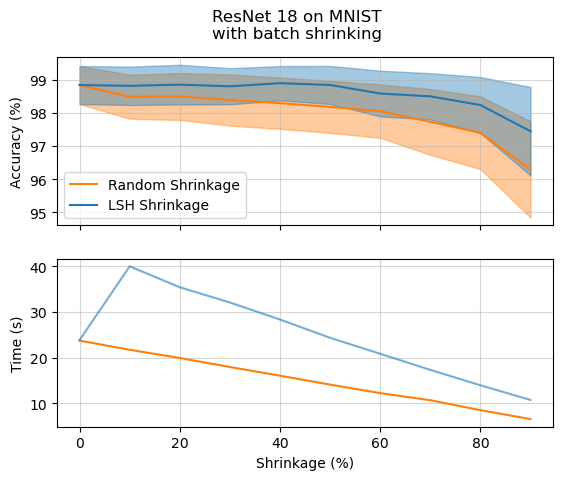

In [10]:
fig, ax = plt.subplots(2,1, sharex = True)
p = [10*i for i in range(10)]

a = 1/2*(acc_res_random[0] + acc_res_lsh[0])
acc_res_random[0] = a
acc_res_lsh[0] = a

b = 1/2*(std_res_random[0] + std_res_lsh[0])
std_res_random[0] = b
std_res_lsh[0] = b

ax[0].grid(alpha = 0.5)
ax[1].grid(alpha = 0.5)

ax[0].plot(p, acc_res_random, c = 'tab:orange', label = 'Random Shrinkage')
ax[0].fill_between(p, acc_res_random - std_res_random, acc_res_random + std_res_random, color = 'tab:orange', alpha = 0.4)
ax[0].plot(p, acc_res_lsh, c = 'tab:blue', label = 'LSH Shrinkage')
ax[0].fill_between(p, acc_res_lsh - std_res_lsh, acc_res_lsh + std_res_lsh, color = 'tab:blue', alpha = 0.4)
ax[0].set_ylabel('Accuracy (%)')

ax[1].plot(p, time_res_random, c = 'tab:orange')
ax[1].plot(p, time_res_lsh, c = 'tab:blue', alpha = 0.6)
ax[1].set_ylabel('Time (s)')

ax[0].legend()
ax[1].set_xlabel('Shrinkage (%)')
fig.suptitle('ResNet 18 on MNIST\nwith batch shrinking')
# plt.savefig('Resnet18_on_MNIST.png')